# Discriminative Sparse Coding

### import libraries

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
class DDSC():
    def __init__(self,train_set,train_sum,gradient_step_size,epsilon,regularization_parameter,steps,n_components,m,T,k):
        """
        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Args:
          gradient_step_size (float): gradiant rate for the convergence step for DD (4b).
          epsilon (float): the gradient stepsize of the pre-training (2b).
          regularization_parameter (float) : weight of penalty function.
          steps (int) : interations to be performed for the convergence part
          param2 (list of str): Description of `param2`. Multiple
            lines are supported.
          param3 (int, optional): Description of `param3`, defaults to 0.
        """
        self.train_set = train_set
        self.train_sum = train_sum
        self.alpha = gradient_step_size
        self.epsilon = epsilon
        self.rp = regularization_parameter
        self.steps = steps
        self.n = n_components
        self.m = m
        self.T = T
        self.k = k

        '''
        Instances that can be used for plotting
        '''
        self.acc_nnsc = None
        self.err_nnsc = None
        self.acc_ddsc = None
        self.err_ddsc = None
        self.a_nnsc = None
        self.b_nnsc = None
        self.a_ddsc = None
        self.b_ddsc = None

    def _initialization(self):
        '''
        will initiualize the matrices A,B with positive values
        scale columns of B s.t b(j) = 1
        '''

        a = np.random.random((self.n,self.m))
        b = np.random.random((self.T,self.n))

        # scale columns s.t. b_i^(j) = 1
        b /= sum(b)
        return a,b

    def accuracy(self,x,x_sum,B,A):
        '''
        Everything needs to be in lists of ndarrays
        of the components
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)

        A_prime = self.F(x_sum.values,B_cat,A=A_cat)
        A_last = np.split(A_prime,self.k,axis=0)
        x_predict = self.predict(A_last,B)
        acc_numerator = (map(lambda i: (np.minimum( (B[i].dot(A_last[i])).sum(), (sum(list(x)[i].sum())))),
                        range(len(B))))
        acc_denominator = sum(x_predict).sum()
        acc = sum(acc_numerator) / acc_denominator
        
        acc_numerator = (map(lambda i: (np.minimum( (B[i].dot(A_last[i])).sum() ,
                        (sum(list(x)[i].sum())))) ,
                        range(len(B))))
        acc_denominator = x_sum.values.sum()
        acc_star = sum(acc_numerator) / acc_denominator
        return acc, acc_star

    def get_accuracy_plot(self):
        return self.acc_nnsc, self.acc_ddsc

    def get_error_plot(self):
        return self.err_nnsc, self.err_ddsc

    def get_a(self):
        return self.a_nnsc, self.a_ddsc

    def get_b(self):
        return self.b_nnsc, self.b_ddsc

    def error(self,x,x_sum,B,A):
        '''
        Error for the whole disaggregation part within list, sum the list to get
        the resulting disaggregation
        Parameters : must have x_train as x
        '''
        B_cat = np.hstack(B)
        A_cat = np.vstack(A)
        
        error = (map(lambda i: ((1.0/2.0)*np.linalg.norm( (x[i] - B[i].dot(A[i]))**2)), range(len(B))))
        
        A_last_error = self.F(x_sum.values,B_cat,A_cat)
        A_last_error_list = np.split(A_last_error,self.k,axis=0)
        error_star = (map(lambda i: ((1.0/2.0)*np.linalg.norm((x[i] - B[i].dot(A_last_error_list[i]))**2)),range(len(B))))
        
        return error, error_star

    def pre_training(self,x):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING
        A_list,B_list = self.nnsc(x)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m = {m} and T = {T} took: {t:.3f}s'.format(m=self.m,T=self.T,t=t))
        return A_list,B_list
    
    
    @staticmethod
    def _pos_constraint(a):
        '''
        # using only the positive values
        '''
        indices = np.where(a < 0.0)
        a[indices] = 0.0
        return a
    
    def nnsc(self,appliances):
        '''
        Method as in NNSC from nonnegative sparse coding finland.
        from P.Hoyer
        TODO:
        implement the coordinate descent algorithm, as of now we are using         gradient descent (not as efficient)
        Also create multiple ndarrays that we take the argmin for.
        '''
        epsilon = 0.01
        acc_nnsc = []
        err_nnsc = []
        a_nnsc = []
        b_nnsc = []
        # used for F
        x_train_sum = self.train_set.values()
        A_list = []
        B_list = []
        for x in appliances:
            # step 1 
            A0, B0 = self._initialization() # initialization 
            Ap, Bp = A0, B0
            Ap1, Bp1 = Ap, Bp # record previous step Ap, Bp
            t = 0
            change_A = 1.0
            while t <= self.steps and change_A >= self.epsilon:
                # step 2a
                Bp = Bp - self.alpha*np.dot((np.dot(Bp,Ap) - x),Ap.T)
                # step 2b
                Bp = self._pos_constraint(Bp)
                # step 2c
                Bp /= sum(Bp)
                # element wise division
                dot2 = np.divide(np.dot(Bp.T,x),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                # step 2d
                Ap = np.multiply(Ap,dot2)

                change_A = np.linalg.norm(Ap - Ap1)
                change_B = np.linalg.norm(Bp - Bp1)
                Ap1, Bp1 = Ap, Bp
                t += 1

                print("iter {t}：A change = {a:8.4f},  B change = {b:8.4f}".format(t=t, a=change_A, b=change_B))

            print("Gone through one appliance")
            A_list.append(Ap)
            B_list.append(Bp)


        # for thesis
        acc_iter = self.accuracy(x_train_sum,self.train_sum,B_list,A_list)
        err_iter = self.error(x_train_sum,self.train_sum,B_list,A_list)
        acc_nnsc.append(acc_iter)
        err_nnsc.append(err_iter)
        # append norm of matrices
        a_nnsc.append(np.linalg.norm(sum(A_list)))
        b_nnsc.append(np.linalg.norm(sum(B_list)))

        self.acc_nnsc = acc_nnsc
        self.err_nnsc = err_nnsc
        self.a_nnsc = a_nnsc
        self.b_nnsc = b_nnsc
        return A_list,B_list
    
    def F(self,x,B,x_train=None,A=None,rp_tep=False,rp_gl=False):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4b
        B = np.asarray(B)
        A = np.asarray(A)
        coder = SparseCoder(dictionary=B.T,
                            transform_alpha=self.rp, transform_algorithm='lasso_cd')
        comps, acts = librosa.decompose.decompose(x,transformer=coder)
        acts = self._pos_constraint(acts)

        return acts

    def DD(self,x,B,A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # step 3
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        change = 1
        t = 0
        acc_ddsc = []
        err_ddsc = []
        a_ddsc = []
        b_ddsc = []
        x_train_sum = self.train_set.values()
        while t <= self.steps and self.epsilon <= change:
            B_cat_p = B_cat
            # step 4a
            acts = self.F(x,B_cat,A=A_star)
            # step 4b
            B_cat = (B_cat-self.alpha*((x-B_cat.dot(acts))
                     .dot(acts.T) - (x-B_cat.dot(A_star)).dot(A_star.T)))
            # step 4c
            # scale columns s.t. b_i^(j) = 1
            B_cat = self._pos_constraint(B_cat)
            B_cat /= sum(B_cat)

            # convergence check
            acts_split = np.split(acts,self.k,axis=0)
            B_split = np.split(B_cat,self.k,axis=1)
            acc_iter = self.accuracy(x_train_sum,self.train_sum,B,acts_split)
            acc_iter = self.accuracy(x_train_sum,self.train_sum,B_split,A)
            err_iter = self.error(x_train_sum,self.train_sum,B,acts_split)
            acc_ddsc.append(acc_iter)
            err_ddsc.append(err_iter)
            a_ddsc.append(np.linalg.norm(acts))
            b_ddsc.append(np.linalg.norm(B_cat))

            change = np.linalg.norm(B_cat - B_cat_p)
            t += 1
            print("step {t}: DD change = {c:.4f}".format(t=t, c=change))

        self.acc_ddsc = acc_ddsc
        self.err_ddsc = err_ddsc
        self.a_ddsc = a_ddsc
        self.b_ddsc = b_ddsc
        return B_cat

    def predict(self,A,B):
        x = map(lambda x,y: x.dot(y),B,A)
        return x

In [3]:
from dataprocess import read_data, format_data, split

df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
135,2014-01-01 00:00:00,1.043,0.840,0.064,0.0,0.0,0.139
135,2014-01-01 01:00:00,0.158,0.000,0.009,0.0,0.0,0.149
135,2014-01-01 02:00:00,1.097,0.759,0.060,0.0,0.0,0.278
135,2014-01-01 03:00:00,0.715,0.522,0.045,0.0,0.0,0.148
135,2014-01-01 04:00:00,0.111,0.000,0.009,0.0,0.0,0.102


In [4]:
d = format_data(df, houses)

In [88]:
factor_n_t = 5 # heuristically determined

timeframes = [14,30,60]
timeframes = [48]
timeframes = [336] # 24*7*2
#timeframes = [x*24 for x in timeframes]
alphas = [0.0001]
#alphas = [0.0001, 0.00001, 0.000001]
portion = 0.5
# Good values (t,n,alpha)
# (14,40, alpha = 0.0001)
# (336,800, alpha = 0.00001)
# (720,,1400, alpha = )
for timeframe, alpha in zip(timeframes,alphas):
#     n = int(factor_n_t*timeframe)
    n = 250
    x_train, x_test = split(d,portion,timeframe)
# use in whole house disaggregation step
    x_train_use = x_train.pop('use',None)
    x_test_use = x_test.pop('use',None)
    x_train_localhour = x_train.pop('localhour',None)
    x_test_localhour = x_test.pop('localhour',None)
# algorithm starts

    # parameters
    train_set = x_train
    test_set = x_test
    train_sum = sum(x_train.values())
    k = len(x_train.keys())
    T,m = x_train[list(x_train.keys())[0]].shape
    rp = 0.0005
    epsilon = 0.001
    alpha = 0.0001
    steps = 100# steps must be higher than k
    # get data
    n_components = n

    # Sparse Coding pre_training
    sc = DDSC(train_set,train_sum,alpha,epsilon,rp,steps,n_components,m,T,k)
    print("started the pre-training")
    A_list,B_list = sc.pre_training(x_train.values())
    print("done pre_training")
    # Discriminative Disaggregation training
    B_cat = sc.DD(x_train_use.values,B_list,A_list)
    print("done DD")
    # Given test examples x_test
    A_prime = sc.F(x_test_use.values,B_cat,A=np.vstack(A_list))
    A_last = np.split(A_prime,k,axis=0)
    x_predict = sc.predict(A_last,B_list)
    print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[0]).shape,))
    x_predict_sum = sum(x_predict)
    
    # energy disaggregation accuracy
    acc = sc.accuracy(x_train.values(),train_sum,B_list,A_last)
    # energy disaggregation error
    error, error_star = sc.error(list(x_train.values()),train_sum,B_list,A_list)
    print("error: %s, error_star: %s" % (sum(error),sum(error_star)))
    acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
    err_nnsc, err_ddsc = sc.get_error_plot()
    # plotting acc/err
    a_nnsc, a_ddsc = sc.get_a()
    b_nnsc, b_ddsc = sc.get_b()

started the pre-training
iter 1：A change =  38.4688,  B change =   0.0881
iter 2：A change =   1.0164,  B change =   0.0186
iter 3：A change =   1.0781,  B change =   0.0188
iter 4：A change =   1.1680,  B change =   0.0190
iter 5：A change =   1.2906,  B change =   0.0193
iter 6：A change =   1.4535,  B change =   0.0197
iter 7：A change =   1.6670,  B change =   0.0202
iter 8：A change =   1.9463,  B change =   0.0207
iter 9：A change =   2.3082,  B change =   0.0213
iter 10：A change =   2.7773,  B change =   0.0220
iter 11：A change =   3.3798,  B change =   0.0228
iter 12：A change =   4.0916,  B change =   0.0234
iter 13：A change =   4.8036,  B change =   0.0235
iter 14：A change =   5.3891,  B change =   0.0233
iter 15：A change =   5.6707,  B change =   0.0219
iter 16：A change =   5.6525,  B change =   0.0193
iter 17：A change =   5.5280,  B change =   0.0173
iter 18：A change =   5.4183,  B change =   0.0167
iter 19：A change =   5.4014,  B change =   0.0163
iter 20：A change =   5.4503,  B ch

In [71]:
x_predict = sc.predict(A_last,B_list)
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[0]).shape,))

the shape of the first predicted appliances is :(24, 21)


In [72]:
x_train.keys()

dict_keys(['air1', 'furnace1', 'dishwasher1', 'regrigerator1', 'other'])

In [73]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

print(np.asarray(list(x_predict)[0])[0:,house])

[0.60616973 2.30891618 3.86936246 3.63835299 1.97465746 1.5922343
 0.30589735 0.28417138 0.01372504 0.02232528 0.24548502 0.21109925
 0.00867146 0.00834435 0.17713001 0.08132819 0.00622828 1.73743041
 0.05058862 0.07602115 0.09915831 0.13002056 0.83473751 0.04032577]


Text(0.5, 0, 'Hours')

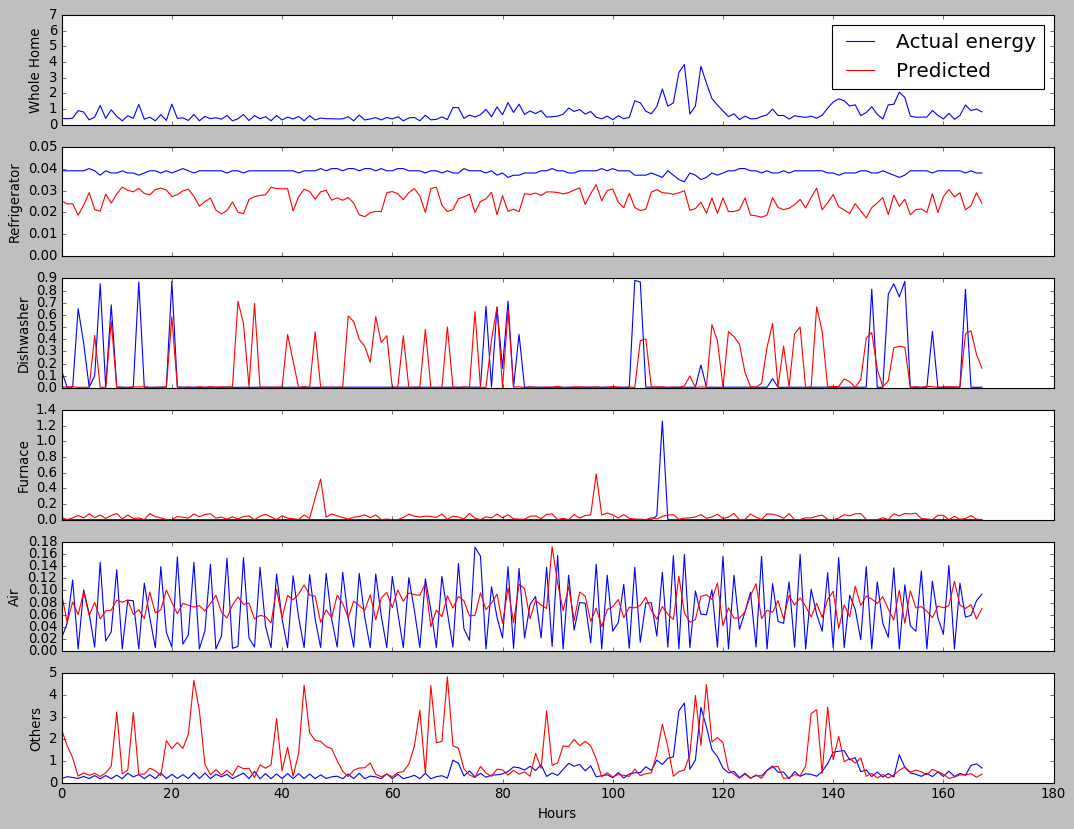

In [167]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('classic')
# row and column sharing
house = 10

pie_chart_true = []
pie_chart_pred = []

f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})


#===========whole home============
y_use_true = np.asarray(x_test_use)[0:,house]
ax1.plot(x, y_use_true, color='b',label='Actual energy')
y_use_pred = [-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y_use_pred, color='r', label='Predicted')
ax1.set_ylim([0,7])
ax1.set_ylabel('Whole Home')
ax1.legend()

#===========regrigerator============
y_ref_true = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
ax2.plot(x, y_ref_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_ref_pred = np.asarray(list(x_predict)[0])[0:,house]
ax2.plot(x, y_ref_pred, color='r')
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')
ax2.set_ylim([0,0.05])


#===========dishwasher============
y_dish_true = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
ax3.plot(x, y_dish_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_dish_pred = np.asarray(list(x_predict)[1])[0:,house]
ax3.plot(x,y_dish_pred, color='r')
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

#===========furnace============
y_fur_true = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
ax4.plot(x, y_fur_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_fur_pred = np.asarray(list(x_predict)[2])[0:,house]
ax4.plot(x,y_fur_pred, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')
# ax4.set_ylim(-0.05, 0.05)

#===========Air============
y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
ax5.plot(x, y_air_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]
ax5.plot(x, y_air_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
# ax5.set_xlabel('Hours')

#===========others============
y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
ax6.plot(x, y_other_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]
ax6.plot(x, y_other_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax6.set_ylabel('Others')
ax6.set_xlabel('Hours')

dict_keys(['air1', 'furnace1', 'dishwasher1', 'regrigerator1', 'other'])


Text(0.5, 1.0, 'Predicted usage')

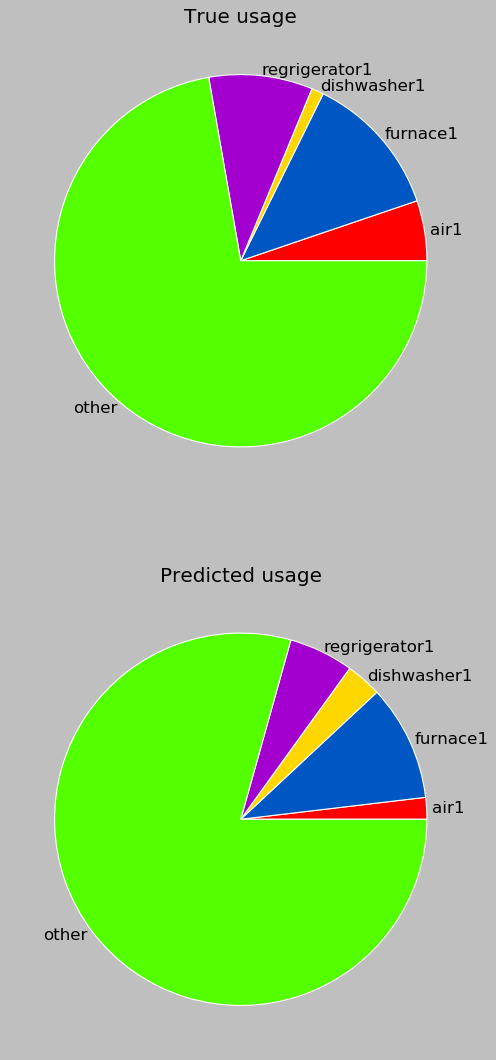

In [160]:
pie_chart_true = [y_ref_true.sum(), y_dish_true.sum(), y_fur_true.sum(), y_air_true.sum(), y_other_true.sum()]
pie_chart_pred = [y_ref_pred.sum(), y_dish_pred.sum(), y_fur_pred.sum(), y_air_pred.sum(), y_other_pred.sum()]



def pie_chart(subplot, pie_chart, labels):
    # The slices will be ordered and plotted counter-clockwise.
    ## --- Plotting the true-piechart
    pie_chart_sum = sum(pie_chart)
    pie_chart = list(map(lambda x: x/pie_chart_sum,pie_chart))
    cmap = plt.cm.prism
    colors = cmap(np.linspace(0., 1., len(pie_chart)))
    pie_wedge_collection = subplot.pie(pie_chart, colors=colors, labels=labels, labeldistance=1.03)

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    
    
f, ((axes1, axes2)) = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(16,16))

labels = x_test.keys()
print(labels)
pie_chart(axes1,pie_chart_true,labels)
axes1.set_title('True usage')
pie_chart(axes2,pie_chart_pred,labels)
axes2.set_title('Predicted usage')
# axes2.text(0.95, 0.01, 'Accuracy of ' + str(round(sc.acc[0],1)), verticalalignment='center', horizontalalignment='right', transform=axes2.transAxes, color='black', fontsize=45)

## Statistical Analysis 

In [170]:
 # plotting acc/err
# a_nnsc, a_ddsc = sc.get_a()
# b_nnsc, b_ddsc = sc.get_b()

print(a_ddsc)

[376.9523329333716, 596.7981227361674, 685.458889136967, 762.3119188029743, 955.9761596640474, 1046.4062560506784, 1280.5214500316404, 1403.0374869130544, 1615.4739725684972, 1998.1272442044733, 2136.6884146517864, 1881.4101665776411, 1993.8201157755984, 2103.2888344988573, 2225.8625802161964, 2332.254852621117, 2611.9901528881414, 3311.168498675437, 2719.382378760038, 2834.4787293725303, 3210.990879242713, 4231.2153153766285, 3915.55699986909, 3696.216187500564, 4248.2786988112775, 2672.056918711177, 2495.0148078791563, 2031.371829924611, 2746.1720040155383, 3127.5150241846463, 2964.738062235956, 2752.5262574582766, 2665.9750032573957, 2150.329425043231, 2544.1098615144406, 2867.169624466204, 2497.032111095957, 2429.916090672955, 2541.6485277017805, 2822.6614413239517, 2492.3580055584307, 2315.8435309206325, 2691.5696207004817, 3487.19806219884, 3192.1406985870585, 2416.8598220194212, 2081.0359032980914, 2525.8010957299853, 2646.7022651546, 2551.3605931790107, 2309.6468936666843, 2271

## Plotting the B matrices (basis functions)

<Figure size 1280x960 with 0 Axes>

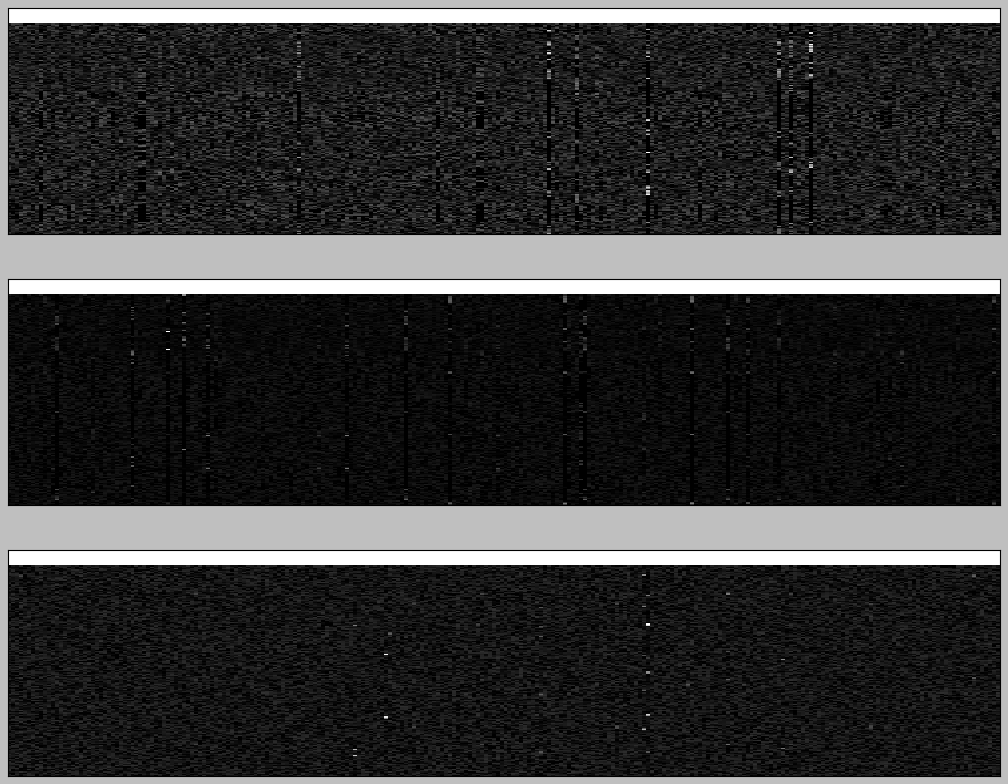

In [161]:
from matplotlib import cm

plt.figure(figsize=(16,12))

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


B_list[0] = B_list[0]/np.sum(B_list[0],axis=1)[:,None]  # Normalize
ax1.pcolor(B_list[0], cmap = cm.Greys_r)
B_list[1] = B_list[1]/np.sum(B_list[1],axis=1)[:,None]  # Normalize
ax2.pcolor(B_list[1], cmap = cm.Greys_r)
B_list[2] = B_list[2]/np.sum(B_list[2],axis=1)[:,None]  # Normalize
ax3.pcolor(B_list[2], cmap = cm.Greys_r)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# plt.savefig(figure_directory+'basis')

Text(0, 0.5, 'Furnace')

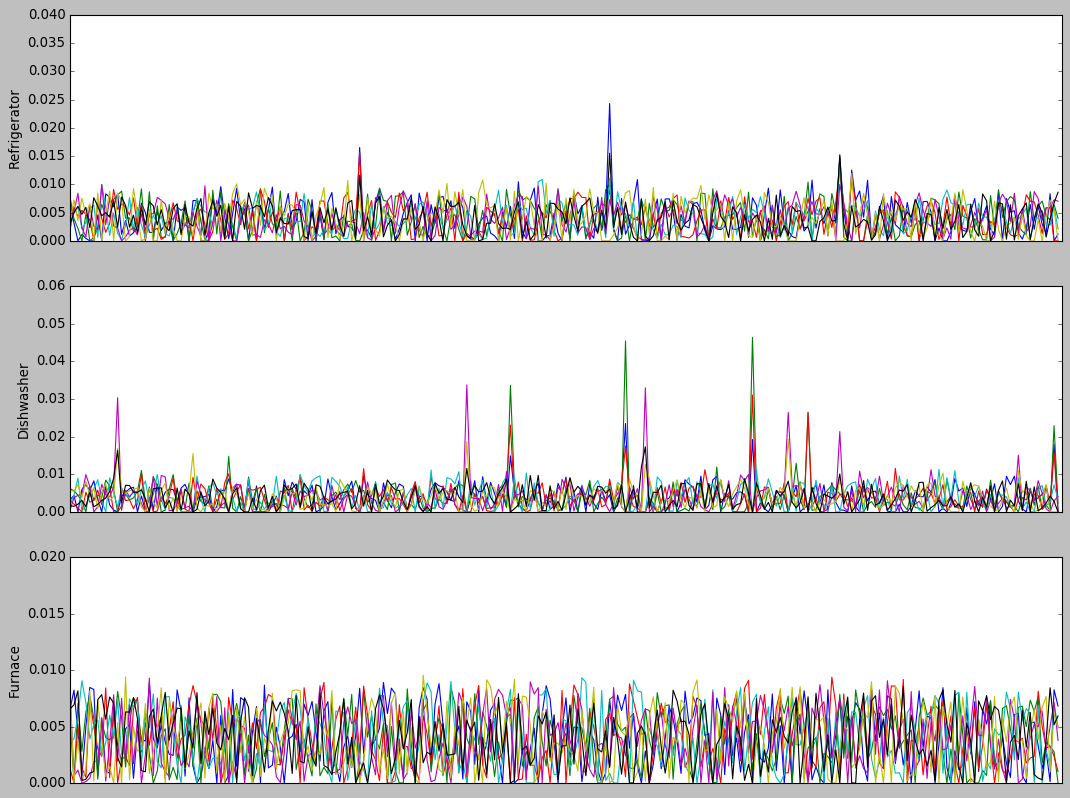

In [158]:
import matplotlib.pyplot as plt
plt.style.use('classic')

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


for base in range(7):
    ax1.plot(range(n),B_list[0][base,0:])
    ax2.plot(range(n),B_list[1][base,0:])
    ax3.plot(range(n),B_list[2][base,0:])

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax1.set_ylim([0,0.04])
ax1.set_ylabel('Refrigerator')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax2.set_ylim([0,0.06])
ax2.set_ylabel('Dishwasher')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax3.set_ylim([0,0.02])
ax3.set_ylabel('Furnace')